# Illustration of a signal with/without memory effect

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gwmemory
from pycbc.waveform import get_td_waveform
from pycbc.filter import highpass
from pycbc.types import TimeSeries
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox



plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "STIXGeneral"
plt.rcParams["font.size"] = 20

/usr/local/lib64/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/usr/local/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


/tmp/ipykernel_54419/830551876.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


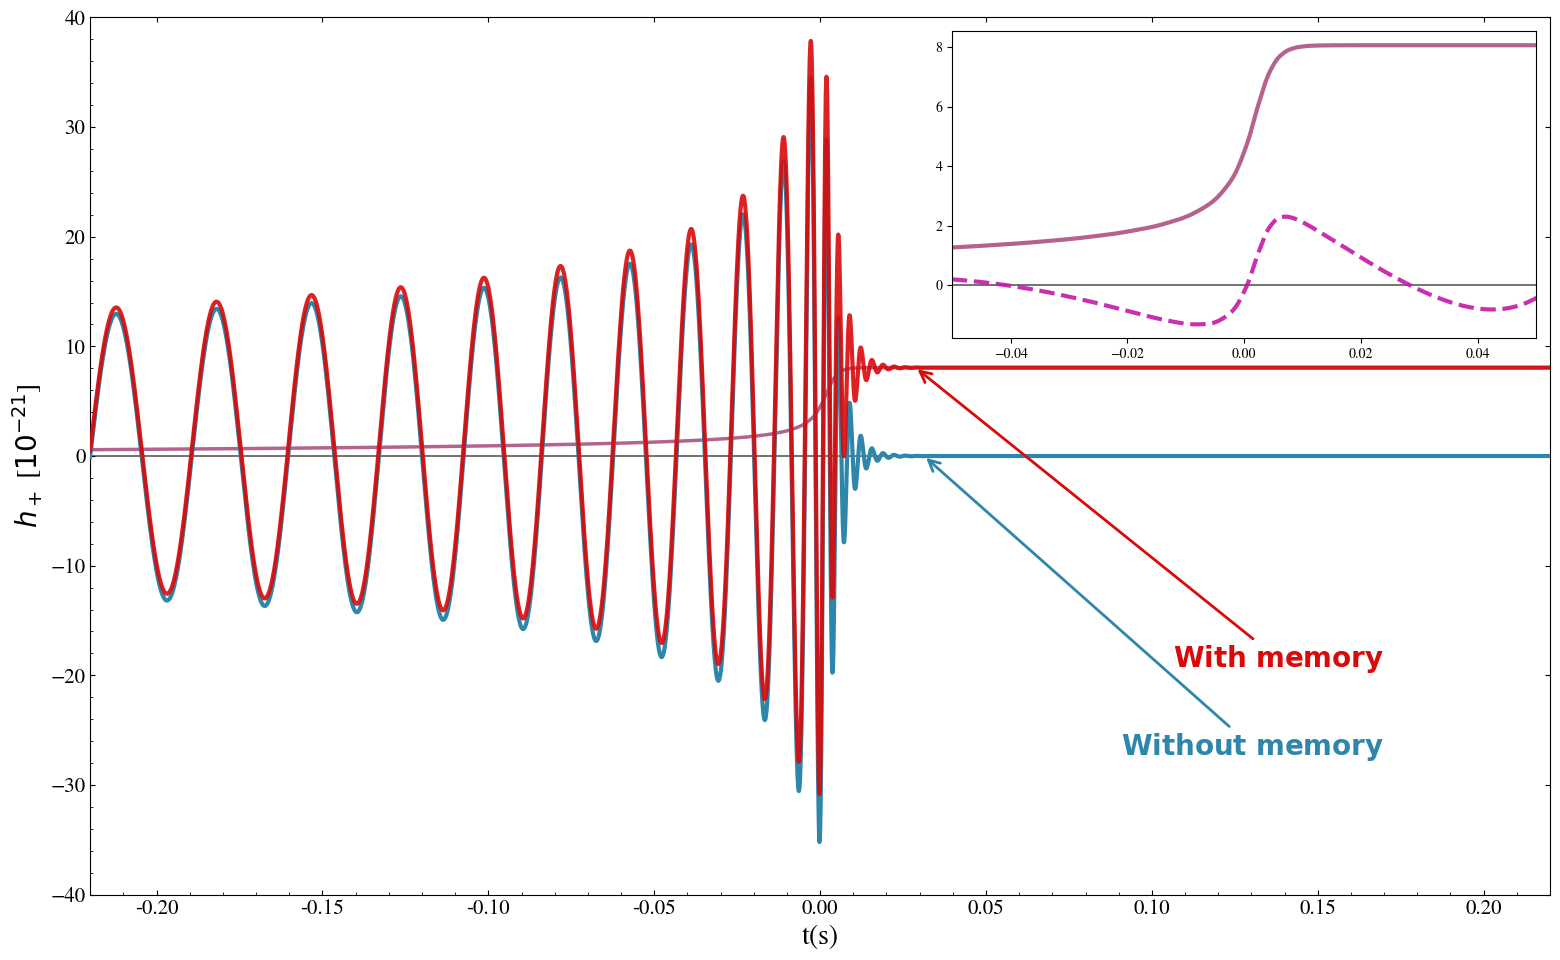

In [ ]:
def create_memory_comparison_plot():
    times = np.linspace(-1.0, 0.05, 10001)
    
    # Parameters for the case to analyze
    params = {
        'total_mass': 60,
        'distance': 10,
        'inc': np.pi/2,  # face-on
        'q': 1.0,
        'phase': 0,
        'spin_1': [0.0, 0.0, 0.0],
        'spin_2': [0.0, 0.0, 0.0],
        'times': times,
        'model': "SEOBNRv4"
    }
    
    # Memory calculation with gwmemory
    h_mem, t_mem = gwmemory.time_domain_memory(**params)
    
    # Oscillatory signal calculation with PyCBC
    hp_osc, hc_osc = get_td_waveform(
        approximant="SEOBNRv4",
        mass1=params['total_mass']/2.0,
        mass2=params['total_mass']/2.0,
        spin1z=params['spin_1'][2],
        spin2z=params['spin_2'][2],
        delta_t=times[1] - times[0],
        f_lower=20.0,
        distance=params['distance'],
        inclination=np.pi/2
    )
    
    # Interpolate the oscillatory signal
    t_osc = hp_osc.sample_times.numpy()
    hp_osc_interp = np.interp(t_mem, t_osc, hp_osc.numpy())
    # Add a zero at the end to extend the signal up to 0.30 s
    if t_mem[-1] < 0.30:
        t_mem = np.append(t_mem, 0.30)
        hp_osc_interp = np.append(hp_osc_interp, 0.0)
        h_mem['plus'] = np.append(h_mem['plus'], h_mem['plus'][-1])

    # Total signal (oscillatory + memory)
    h_total = hp_osc_interp + h_mem['plus']
    
    # Memory signal filtered at 10 Hz
    mem_ts = TimeSeries(h_mem['plus'], delta_t=times[1] - times[0])
    h_mem_filtered = highpass(mem_ts, 10.0).numpy()
    
    # MAIN FIGURE CREATION 
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # Plot oscillatory signal only
    ax.plot(t_mem, hp_osc_interp * 1e21, 
            color='#2E86AB', linestyle='-', linewidth=3, 
            label='Oscillatory waveform', zorder=3)
    
    # Plot total signal (oscillatory + memory)
    ax.plot(t_mem, h_total * 1e21, 
            color='#D90A0A', linestyle='-', linewidth=3, alpha=0.9,
            label='Oscillatory + Memory', zorder=4)
    # Plot memory only
    ax.plot(t_mem, h_mem['plus'] * 1e21,
               color='#A23B72', linestyle='-', linewidth=2.5,
               label='Memory (raw)', alpha=0.8)
    
    # Reference lines
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.1, alpha=0.7, zorder=1)
    
    # Main axis configuration
    ax.set_ylabel(r'$h_+$ [$10^{-21}$]', fontsize=20)
    ax.set_xlabel('t(s)', fontsize=20)
    ax.set_xlim(-0.22, 0.22)
    ax.set_ylim(-40, 40)
    
    # Tick configuration
    ax.tick_params(top=True, right=True, axis='both', which='major', labelsize=15, direction='in')
    ax.tick_params(axis='both', which='minor', labelsize=12, direction='in')
    ax.set_xticks(np.arange(-0.2, 0.2, 0.05))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_major_locator(MultipleLocator(0.05))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.minorticks_on()
    
    # === CREATE TOP RIGHT INSET ===
    axins = inset_axes(ax, width="40%", height="35%", loc='upper right',
                       bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes)
    
    # Plot raw memory in the inset
    axins.plot(t_mem, h_mem['plus'] * 1e21,
               color='#A23B72', linestyle='-', linewidth=3,
               label='Memory signal', alpha=0.8)
    
    # Plot filtered memory in the inset
    axins.plot(t_mem, h_mem_filtered * 1e21,
               color="#C318A6", linestyle='--', linewidth=3,
               label='Memory (10Hz filtered)', alpha=0.9)
    
    # Inset configuration
    axins.set_xlim(-0.05, 0.05)
    #axins.set_xlabel('t(s)', fontsize=12)
    #axins.set_ylabel(r'$h_{\mathrm{mem}}$ [$10^{-21}$]', fontsize=12)
    axins.tick_params(labelsize=10)

    # Reference line in the inset
    axins.axhline(y=0, color='black', linestyle='-', linewidth=1.1, alpha=0.7, zorder=-1)
    
    # Add arrows pointing to the "Oscillatory + Memory" and "Oscillatory waveform" signals

    idx_mem = np.argmax(np.abs(h_total)) + 300
    idx_osc = np.argmax(np.abs(hp_osc_interp)) + 300

    # Arrow origin (bottom right of the main plot)
    arrow_origin_x = ax.get_xlim()[1] - 0.05
    arrow_origin_y = ax.get_ylim()[0] + 20

    # Arrow to "Oscillatory + Memory"
    ax.annotate(
        r'$\mathbf{With\ memory}$',
        xy=(t_mem[idx_mem], h_total[idx_mem] * 1e21),
        xytext=(arrow_origin_x, arrow_origin_y),
        arrowprops=dict(facecolor='#D90A0A', edgecolor='#D90A0A', arrowstyle='->', lw=2),
        color='#D90A0A',
        fontsize=20,
        ha='right',
        va='bottom'
    )

    # Arrow to "Oscillatory waveform"
    ax.annotate(
        r'$\mathbf{Without\ memory}$',
        xy=(t_mem[idx_osc], hp_osc_interp[idx_osc] * 1e21),
        xytext=(arrow_origin_x, arrow_origin_y - 8),
        arrowprops=dict(facecolor='#2E86AB', edgecolor='#2E86AB', arrowstyle='->', lw=2),
        color='#2E86AB',
        fontsize=20,
        ha='right',
        va='bottom'
    )

    plt.tight_layout()
    plt.show()

create_memory_comparison_plot()

# Memory vs Mass Ratio, Distance, Inclination in frequency domain

Should import the different functions from the other scripts to generate the plots properly

In [ ]:
# Compute the Spin-weighted spherical harmonic modes (l,m)
# Definition from : https://arxiv.org/pdf/0812.0069#page=5.61
def fac(n): # Défini n! 
    if n==0 or n==1:
        return 1
    result = 1
    for i in range(2, n+1):
        result *= i
    return result

def dlms(l, m, s, Theta): # eq (2.14)
    
    sq = np.sqrt(fac(l+m)*fac(l-m)*fac(l+s)*fac(l-s))
    d = 0.
    for k in range(max(0,m-s),min(l+m,l-s)+1):
        d = d + (-1.)**k*np.sin(Theta/2.)**(2.*k+s-m)*np.cos(Theta/2.)**(2.*l+m-s-2.*k)/(fac(k)*fac(l+m-k)*fac(l-s-k)*fac(s-m+k))
    return sq*d

def sYlm(s,l,m,Theta,Phi): # eq (2.13)
    
    res = (-1.)**(-s)*np.sqrt((2.*l+1)/(4*np.pi))*dlms(l,m,-s,Theta)
    
    if res==0:
        return 0
    else:
        return complex(res*np.cos(m*Phi), res*np.sin(m*Phi)) # e^(imPhi)

In [ ]:
# function that returns lambda_1 lambda_2 for a given value of lambda_tilde and a mass ratio q
def Lambdas_for_approx(lam_tilde, q):
    lambda1 = lam_tilde * (13/16) * (1 + q)**5 / (q**4 * (q+12) + q**5 * (1+12*q))
    lambda2 = lambda1 * q**5
    return lambda1, lambda2
    

In [ ]:
from lal import PC_SI, C_SI
deltaT = 1.0 / 4096
# Modification of functions to directly include tilt + function to directly calculate memory
def generate_waveform_22(hp, hc, inclination):
    """
    Génère le mode (2,2) à partir de hp et hc, avec inclination passée en paramètre.
    """
    h22 = (hp - 1.j*hc) / sYlm(-2, 2, 2, inclination, np.pi/2)
    return h22

def compute_memory_corrected(deltaT, h22, distance, inclination):
    """
    Mémoire non-linéaire avec normalisation physique correcte, avec inclination passée en paramètre.
    """
    dt = deltaT
    hdot = np.gradient(h22, dt)
    hdot_c = np.conjugate(hdot)
    integrand = hdot * hdot_c
    cumint = np.cumsum(integrand) * dt
    prefactor = (distance * 10**6 * PC_SI / C_SI) * (np.sin(inclination))**2 * (17 + np.cos(inclination)**2) / (192 * np.pi)
    hmem = prefactor * cumint 
    return np.real(hmem)
# New function that returns memory without having to call intermediate functions
def generate_h_mem(mtot, lam_tilde, q, distance, inclination, extension_time=0.2, approximant="IMRPhenomPv2_NRTidal"):

    m1 = mtot / (1 + q)
    m2 = q * m1
    lambda1, lambda2 = Lambdas_for_approx(lam_tilde, q)
    print(f'Value of lambda1: {lambda1}, lambda2: {lambda2} for q={q} and lam_tilde={lam_tilde}')

    hp, hc = get_td_waveform(
        approximant=approximant,
        mass1=m1, mass2=m2,
        lambda1=lambda1, lambda2=lambda2,
        delta_t=deltaT,
        f_lower=20.,
        distance=distance, 
        inclination=inclination, 
        tc=0.0,
        spin_1z=0.0, spin_2z=0.0, 
        spin_1y=0.0, spin_2y=0.0,
        spin_1x=0.0, spin_2x=0.0, 
        phase = 0.0
    )
    hp_orig = hp.numpy()
    hc_orig = hc.numpy()
    t_orig = hp.sample_times.numpy()
    
    amplitude = np.abs(hp_orig)
    merger_idx = np.argmax(amplitude)
    merger_time = t_orig[merger_idx]
    t_aligned = t_orig - merger_time
    
    n_extension = int(extension_time / deltaT)
    hp_extension = np.zeros(n_extension)
    hc_extension = np.zeros(n_extension)
    t_extension = np.arange(1, n_extension + 1) * deltaT + t_aligned[-1]
    
    t_full = np.concatenate([t_aligned, t_extension])
    hp_full = np.concatenate([hp_orig, hp_extension])
    hc_full = np.concatenate([hc_orig, hc_extension])
    
    h22 = generate_waveform_22(hp_full, hc_full, inclination)

    hmem = compute_memory_corrected(deltaT, h22, distance, inclination)
    
    return t_full, hmem

Value of lambda1: 0.0, lambda2: 0.0 for q=1.0 and lam_tilde=0
Value of lambda1: 100.0, lambda2: 100.0 for q=1.0 and lam_tilde=100
Value of lambda1: 200.0, lambda2: 200.0 for q=1.0 and lam_tilde=200
Value of lambda1: 600.0, lambda2: 600.0 for q=1.0 and lam_tilde=600
Value of lambda1: 1000.0, lambda2: 1000.0 for q=1.0 and lam_tilde=1000
Value of lambda1: 1400.0, lambda2: 1400.0 for q=1.0 and lam_tilde=1400
Value of lambda1: 1800.0, lambda2: 1800.0 for q=1.0 and lam_tilde=1800


/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


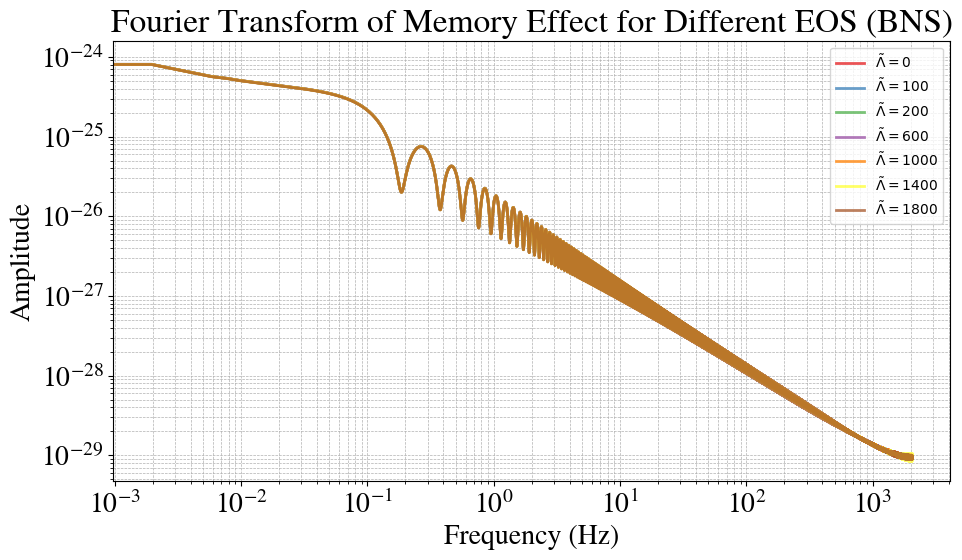

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
deltaT = 1.0 / 4096
distance = 100.0
inclination = np.pi / 2
Mtot = 2.7  

# Different values of lambda_tilde to consider
lambda_values = [0, 100, 200, 600, 1000, 1400, 1800]

cmap = plt.cm.Set1  
colors = [cmap(i) for i in range(len(lambda_values))]

fig, ax = plt.subplots(figsize=(10, 6))

for i, lam in enumerate(lambda_values):

    _, hmem = generate_h_mem(
        mtot=Mtot,
        lam_tilde=lam,
        q=1.0,
        distance=distance,
        inclination=inclination,
        extension_time=0.2,
        approximant="IMRPhenomPv2_NRTidal"
    )
    
    # Compute FFT
    N = len(hmem)
    T = deltaT
    yf = fft(hmem)
    xf = fftfreq(N, T)[:N//2] 
    amplitude = 2.0 / N * np.abs(yf[0:N//2])
    ax.plot(xf, amplitude, color=colors[i], label=rf'$\tilde{{\Lambda}} = {lam}$', linewidth=2, alpha=0.75)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title('Fourier Transform of Memory Effect for Different EOS (BNS)')
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

Value of lambda1: 255426.64670658694, lambda2: 4.3256726905889495 for q=0.1111111111111111 and lam_tilde=350
Value of lambda1: 24395.70922851564, lambda2: 13.22059129388305 for q=0.2222222222222222 and lam_tilde=350
Value of lambda1: 6933.333333333333, lambda2: 28.532235939643336 for q=0.3333333333333333 and lam_tilde=350
Value of lambda1: 3003.255277467006, lambda2: 52.08104123907625 for q=0.4444444444444444 and lam_tilde=350
Value of lambda1: 1617.0259030837003, lambda2: 85.57648642883986 for q=0.5555555555555556 and lam_tilde=350
Value of lambda1: 991.8212890625, lambda2: 130.61021090534976 for q=0.6666666666666666 and lam_tilde=350
Value of lambda1: 662.9550854403788, lambda2: 188.69559384572875 for q=0.7777777777777777 and lam_tilde=350
Value of lambda1: 470.9097516005206, lambda2: 261.3214574412074 for q=0.8888888888888888 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350


/tmp/ipykernel_54419/3900922501.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


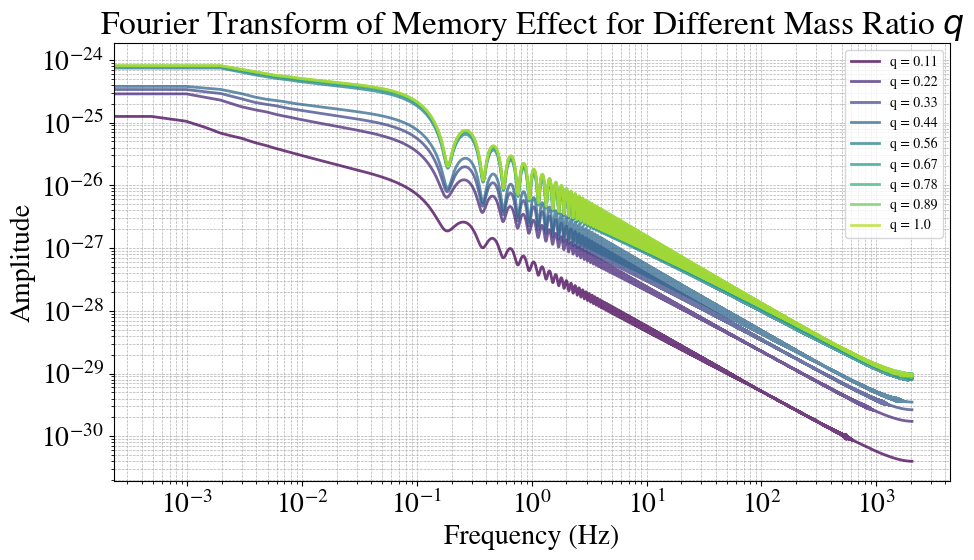

In [ ]:
deltaT = 1.0 / 4096
distance = 100.0
inclination = np.pi / 2
Mtot = 2.7  

q_array = np.linspace(0.0, 1.0, 10)[1:]  # Exclude q=0 to avoid division by zero

cmap = plt.cm.viridis 
colors = [cmap(i / len(q_array)) for i in range(len(q_array))]

fig, ax = plt.subplots(figsize=(10, 6))

for i,q in enumerate(q_array):

    _, hmem = generate_h_mem(
        mtot=Mtot,
        lam_tilde=350,  # fix value of lambda_tilde
        q=q,
        distance=distance,
        inclination=inclination,
        extension_time=0.2,
        approximant="IMRPhenomPv2_NRTidal"
    )
    N = len(hmem)
    T = deltaT
    yf = fft(hmem)
    xf = fftfreq(N, T)[:N//2]
    amplitude = 2.0 / N * np.abs(yf[0:N//2])
    
    ax.plot(xf, amplitude, color=colors[i], label=f'q = {np.round(q, 2)}', linewidth=2, alpha=0.75)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(rf'Fourier Transform of Memory Effect for Different Mass Ratio $q$')
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
        
 

Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350


/tmp/ipykernel_54419/3823020312.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


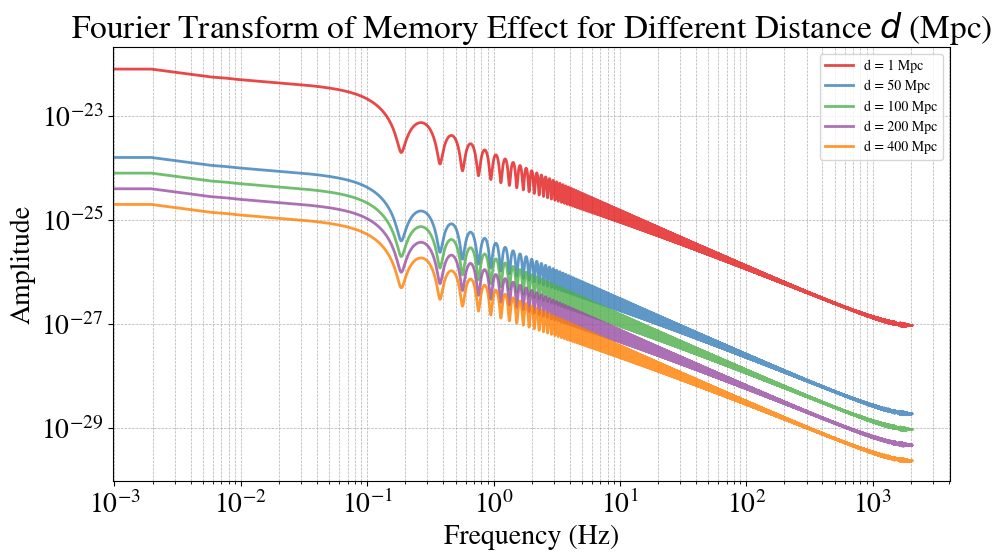

In [ ]:
deltaT = 1.0 / 4096
q= 1.0
inclination = np.pi / 2
Mtot = 2.7 

cmap = plt.cm.Set1  
distances = [1, 50, 100, 200, 400]  # different distance in Mpc
colors = [cmap(i) for i in range(len(distances))]

fig, ax = plt.subplots(figsize=(10, 6))

for i,dist in enumerate(distances):

    _, hmem = generate_h_mem(
        mtot=Mtot,
        lam_tilde=350,  # fix value of lambda_tilde
        q=q,
        distance=dist,
        inclination=inclination,
        extension_time=0.2,
        approximant="IMRPhenomPv2_NRTidal"
    )
    
    # Calcul de la FFT
    N = len(hmem)
    T = deltaT
    yf = fft(hmem)
    xf = fftfreq(N, T)[:N//2]
    amplitude = 2.0 / N * np.abs(yf[0:N//2])
    
    ax.plot(xf, amplitude, color=colors[i], label=f'd = {dist} Mpc', linewidth=2, alpha=0.8)


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(rf'Fourier Transform of Memory Effect for Different Distance $d$ (Mpc)')
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
        
 

Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1.0 and lam_tilde=350


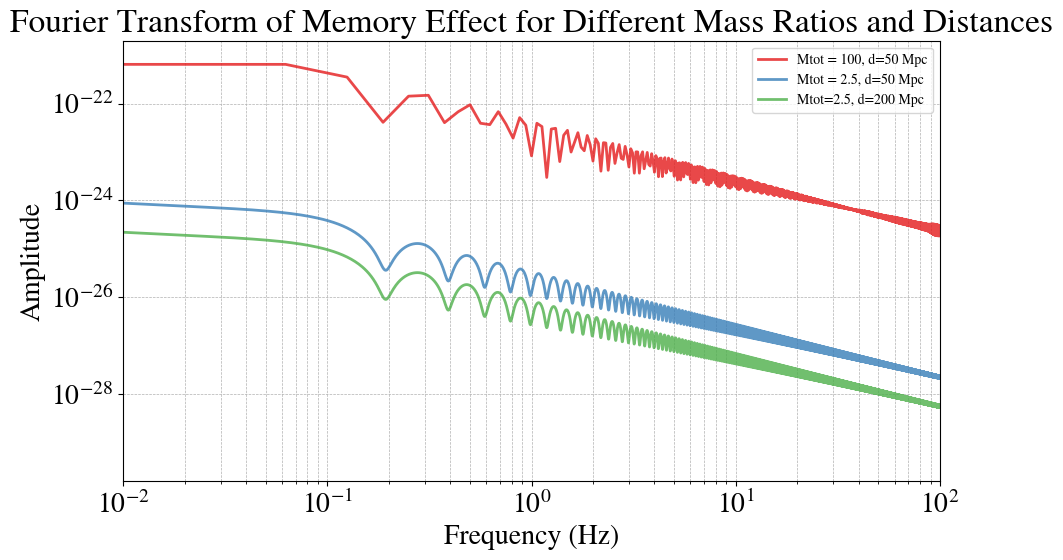

In [ ]:
# 3 plots to compare mass ratio and distance effects
deltaT = 1.0 / 4096
inclination = np.pi / 2
Mtot = 2.7 
cases = [
    {'Mtot' : 100.0, 'q': 1.0, 'distance': 50, 'label': 'Mtot = 100, d=50 Mpc'},
    {'Mtot' : 2.5,'q': 1.0, 'distance': 50, 'label': 'Mtot = 2.5, d=50 Mpc'},
    {'Mtot' : 2.5,'q': 1.0, 'distance': 200, 'label': 'Mtot=2.5, d=200 Mpc'}
]
cmap = plt.cm.Set1
colors = [cmap(i) for i in range(len(cases))]
fig, ax = plt.subplots(figsize=(10, 6))
for i, case in enumerate(cases):
    _, hmem = generate_h_mem(
        mtot=case['Mtot'],
        lam_tilde=350,
        q=1.0,
        distance=case['distance'],
        inclination=inclination,
        extension_time=0.0,
        approximant="IMRPhenomPv2_NRTidal"
    )
    N = len(hmem)
    T = deltaT
    yf = fft(hmem)
    xf = fftfreq(N, T)[:N//2]
    amplitude = 2.0 / N * np.abs(yf[0:N//2])
    ax.plot(xf, amplitude, color=colors[i], label=case['label'], linewidth=2, alpha=0.8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
ax.set_title(r'Fourier Transform of Memory Effect for Different Mass Ratios and Distances')
ax.legend(fontsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_xlim(1e-2, 1e2)
plt.tight_layout()
plt.show()

Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of lambda1: 350.0, lambda2: 350.0 for q=1 and lam_tilde=350
Value of l

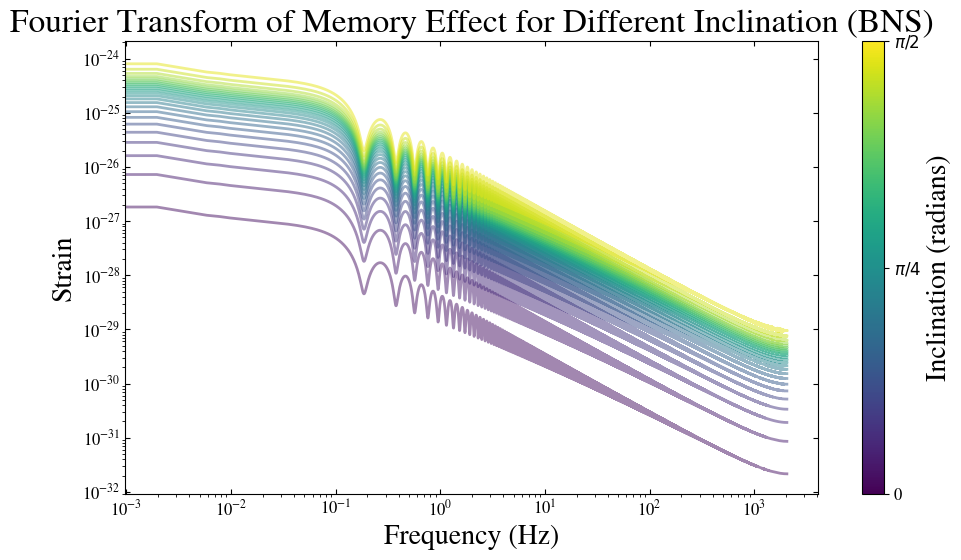

In [ ]:
from matplotlib import cm
from scipy.fft import fft, fftfreq

deltaT = 1.0 / 4096
distance = 100.0
Mtot = 2.7 
q= 1 # fix mass ratio
eps = 1e-8
incl_array = np.linspace(0, np.pi /2, 25) 
cmap = plt.cm.viridis 
colors = [cmap(i / len(incl_array)) for i in range(len(incl_array))]


fig, ax = plt.subplots(figsize=(10, 6))

for i,incl in enumerate(incl_array):

    _,hmem = generate_h_mem(Mtot, 350, q, distance, incl, extension_time=0.2)

    N = len(hmem)
    T = deltaT
    yf = fft(hmem)
    xf = fftfreq(N, T)[:N//2]
    amplitude = 2.0 / N * np.abs(yf[0:N//2])
    ax.plot(xf, amplitude, color=colors[i], label=f'i = {np.round(incl, 2)}', linewidth=2, alpha=0.5)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Strain')
ax.set_title(rf'Fourier Transform of Memory Effect for Different Inclination (BNS)')


norm = plt.Normalize(vmin=0, vmax=np.pi/2)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Inclination (radians)')
cbar.set_ticks([0, np.pi/4, np.pi/2])
cbar.set_ticklabels(['0', r'$\pi/4$', r'$\pi/2$'])
cbar.ax.tick_params(labelsize=12)

ax.tick_params(top=True, right=True, axis='both', which='major', labelsize=12, direction='in')
plt.tight_layout()
plt.show()